In [ ]:
from tqdm import tqdm
import os
from datasets import load_dataset
import json
import nltk
import re
import difflib
from copy import deepcopy

import asyncio
import math
import json
import numpy as np
import random
import pandas as pd
from ollama import AsyncClient

/root/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
client_ollama = AsyncClient(
  host='http://192.168.1.5:11434',
)

async def chat(content,image_path):
    message = {'role': 'user', 'content': content}
    if image_path != None:
        message.update({'images': [image_path]})
    response = await client_ollama.chat(model='llama3.2-vision', messages=[message],options={"temperature":0.4})
    return response['message']['content']

In [14]:
def save_image(image, path, format=None):
    try:
        image.save(path, format=format)
    except Exception as e:
        print(f"An error occurred while saving the image: {e}")

def crop_lower_part(image, crop_height):
    width, height = image.size
    box = (0, 0, width, height - crop_height)
    return image.crop(box)

def get_image_path(question_object):
    # TODO check if is a eppo questioin object
    base_url = '/workdir/images/EPPO/'
    image_url = eval(question_object['metadata'])['url'].split('/')
    image_name = image_url[-4]+'_'+image_url[-1]
    image_path = base_url + image_name
    return image_path

In [178]:
def options_refactor(options):
    list_options = eval(options)
    if len(list_options)>6:
        print(list_options)
        return ''
    OPTIONS = ['A','B','C','D','E','F']
    list_with_letter = [OPTIONS[i]+' '+list_options[i] for i in range(len(list_options))]
    return ' \n'.join(list_with_letter)
    

In [306]:
def extract_answer(result):
    # Remove '*' and find the part starting from 'Answer:'
    cleaned_result = result.replace('*', '')
    answer_part = cleaned_result[cleaned_result.find('Answer:'):]
    
    # Split the answer and get the last part
    if 'Answer:' in answer_part:
        answer = answer_part.split(':')[-1].strip()
        
        # Check if the first character of the answer is between A and E
        if answer and answer[0] in 'ABCDE':
            return answer[0]
    
    return None

strategy_1 = {
    'end_prompt': (
        '\nCarefully evaluate the question and select the most appropriate option. '
        'If you are unsure or unable to answer, respond with "I don’t know". '
        'Otherwise, respond using only the capital letter (A, B, C, D, or E) '
        'of the correct option, without any punctuation or additional text.'
    ),
    'answer_extraction': lambda answer: answer.strip()[0] if answer.strip()[0] in 'ABCDE' else None
}

strategy_2 = {
    'end_prompt': (
        '\nConsider the question and evaluate all the options carefully. Once you have identified the correct answer, '
        'provide your response in the following format: "Answer: <option_letter>". '
        'If you are uncertain or cannot determine the correct answer, write "Answer: I don’t know".'
    ),
    'answer_extraction': extract_answer
}





In [307]:
async def ask_question(question_object,strategy=strategy_1,image=False):
    question = question_object['question'].replace(' <image 1>','')
    options = question_object['options']
    if image:
        image_paths = get_image_path(question_object)
    else:
        image_paths = None
    end_prompt = strategy['end_prompt']
    response = await chat(question+'\nOptions:\n'+options_refactor(options)+end_prompt, image_paths)
    answer_extraction = strategy['answer_extraction']
    return {'verbose_response':response, "LLM_response" : answer_extraction(response), "question_object" : question_object}

In [312]:
task = 'Identification'
ds = load_dataset("parquet", data_files={'validation': '/workdir/important_datasets/AGRIVQA/'+task+'/validation-*.parquet',
                                               'dev': '/workdir/important_datasets/AGRIVQA/'+task+'/dev-*.parquet',
                                               'test': '/workdir/important_datasets/AGRIVQA/'+task+'/test-*.parquet'})

Generating validation split: 80 examples [00:00, 329.14 examples/s]
Generating dev split: 10 examples [00:00, 423.60 examples/s]
Generating test split: 10 examples [00:00, 323.71 examples/s]


In [313]:
ds_list = list(ds['validation'])

In [314]:
def count_accuracy(results):
    OPTIONS = ['A', 'B','C','D', 'E']
    c=0
    for result in results:
        LLM_letter=result['LLM_response']
        if LLM_letter in OPTIONS:
            index_LLM = OPTIONS.index(result['LLM_response'])
        else:
            print('ERROR',result['LLM_response'])
            print(result['question_object']['question'])
            print(result['verbose_response'])
            continue
        if LLM_letter != result['question_object']['answer']:
            c+=1
    return int((1-(c/len(results)))*100)

In [352]:

# Download Image for Identification

def download_GBIF(ds):
    names = []
    for obj in tqdm(ds):
        if isinstance(eval(obj['metadata'])['url'],list):
            for i, url in enumerate(eval(obj['metadata'])['url']):
                name = url.split('/')[-1]
                obj['image_'+str(i+1)].save('/workdir/important_datasets/AGRIVQA_images/GBIF/'+name+'.png')
        else:
            name = eval(obj['metadata'])['url'].split('/')[-1]
            obj['image_1'].save('/workdir/important_datasets/AGRIVQA_images/GBIF/'+name+'.png')
        names.append(name)
    return names

In [315]:
random.seed(1)
ds_50 = random.sample(ds_list,50)

In [321]:
ds_50[0]

{'id': 'validation_Identification_18',
 'question': 'What is the scientific name of the plant shown in <image 1>?',
 'options': "['Ulex jussiaei', 'Ulex europaeus', 'Ulex parviflorus', 'Ulex breoganii']",
 'explanation': '',
 'image_1': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=800x533>,
 'image_2': None,
 'image_3': None,
 'image_4': None,
 'image_5': None,
 'img_type': "['Picture']",
 'answer': 'B',
 'topic_difficulty': '5',
 'question_type': 'multiple-choice',
 'subfield': 'scientific_name_4',
 'metadata': '{"source": "PlantNet", "author": "PlantNet", "license": "CC BY-SA 4.0", "url": "https://bs.plantnet.org/image/o/eeff77866c6716302437d36d4a741e3b31996007", "gbif_id": 2643482620, "eppo_code": ["ULEEU"], "gbif_key": 2951984, "kingdom": "Plantae", "tag": "scientific_name_4", "region": "Africa", "event_date": "2012-11-26T00:00Z", "language": "English"}'}

In [353]:
names=download_GBIF(ds_50)

100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


In [354]:
len(names)

50

In [344]:
len(os.listdir('/workdir/important_datasets/AGRIVQA_images/GBIF'))

27

In [316]:
tasks=[]
for q in ds_50:
    tasks.append(ask_question(q, strategy = strategy_2, image = True))
results = await asyncio.gather(*tasks)
print('Accuracy: ',count_accuracy(results),'%')

PydanticSerializationError: Error calling function `serialize_model`: ValueError: Invalid image data, expected base64 string or path to image file

In [ ]:
#Agriexam
#strategy_1 = 50% / 52% / 54% / 52% / 52% (Only letter as output)
#strategy_2 = 65% / 65% / 65% / 58% / 68% (Possibility to think)
# EPPO
# (1m 34s) strategy_1 = 68% / 70% / 74% / 78% / 78%
# (3m 30s) strategy_2 = 70% / 78% / 80% / 72%



In [ ]:
OPTIONS = ['A', 'B','C','D', 'E']
c=0
for result in results:
    #if not result[0]:
        
        options_list = eval(result['question_object']['options'])
        index_ground = OPTIONS.index(result['question_object']['answer'])
        LLM_letter=result['LLM_response']
        if LLM_letter in OPTIONS:
            index_LLM = OPTIONS.index(result['LLM_response'])
        else:
            print('ERROR',result['LLM_response'])
            
            continue
        if LLM_letter != result['question_object']['answer']:
            c+=1
            print(result['question_object']['id'])
            print(result['question_object']['question'].replace(' <image 1>',''))
            print(result['question_object']['options'])
            #print(get_image_path(result['question_object']))
            #print(result['question_object']['options_difficulty'])
            print('LLM: ',result['LLM_response'],'|','Correct: ',result['question_object']['answer'])
            print('LLM: ',options_list[index_LLM],'|','Correct: ', options_list[index_ground])
            print('*'*30)

test__agriexam_4
Most popular variety of Mango in North India?
['Dashari', 'Langda', 'Alfanso', 'Neelam', 'All of these']
LLM:  E | Correct:  A
LLM:  All of these | Correct:  Dashari
******************************
test__agriexam_7
Flagellated larva of Leucosolenia is called?
['Planula', 'Parenchymula', 'Hydrula', 'Amphiblastula']
LLM:  D | Correct:  B
LLM:  Amphiblastula | Correct:  Parenchymula
******************************
test__agriexam_8
Weed seeds which are difficult to separate out once mixed with crop seeds are known as
['noxious', 'poisonous', 'parasitic', 'objectionable']
LLM:  C | Correct:  D
LLM:  parasitic | Correct:  objectionable
******************************
test__agriexam_14
The Ganga KalyanYojana is for:
['Credit support scheme for small farmers.', 'Credit support scheme for rural people', 'Irrigation for small and marginal farmers', 'Consumption purpose of farmers']
LLM:  A | Correct:  C
LLM:  Credit support scheme for small farmers. | Correct:  Irrigation for small

ERROR None
Accuracy:  78 %


In [287]:
options_list=eval(result[2]['options'])

In [288]:
index=OPTIONS.index('A')

In [289]:
options_list[index]

'delicate laurel'

In [266]:
import os
from PIL import Image

def crop_all_images_in_directory(directory, crop_height):
    """
    Process all images in a directory, crop them, and save them back.
    
    Parameters:
        directory (str): The directory containing the images.
        crop_height (int): The height to crop from the bottom of each image.
    """
    # Loop over all files in the directory
    for filename in tqdm(os.listdir(directory)[1700:]):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):  # Check if the file is an image
            file_path = os.path.join(directory, filename)
            
            try:
                # Open the image
                with Image.open(file_path) as img:
                    # Crop the image
                    cropped_img = crop_lower_part(img, crop_height)
                    
                    # Save the cropped image back to the same path
                    cropped_img.save(file_path)
            except Exception as e:
                print(f"Error processing {filename}: {e}")


In [ ]:
await ask_question(ds_list[7])

Image successfully saved to /workdir/images/cache/prova.png


(True,
 'C',
 {'id': 'test__EPPO_8',
  'question': 'At what growth stage is this animal? <image 1>',
  'options': "['egg', 'larva', 'adult', 'pupa']",
  'explanation': None,
  'image_1': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1282>,
  'image_2': None,
  'image_3': None,
  'image_4': None,
  'image_5': None,
  'img_type': "['Picture']",
  'answer': 'C',
  'options_difficulty': '1',
  'question_type': 'multiple-choice',
  'subfield': 'Animalia / growth_stage',
  'metadata': '{"source": "EPPO", "author": "EPPO", "license": "", "url": "https://gd.eppo.int/media/data/taxon/D/DACUDO/pics/1024x0/14594.jpg", "language": "English", "verbose_answer": "{verbose_answer}", "eppo_code": "DACUDO", "gbif_key": "7930834", "kingdom": "Animalia", "tag": "growth_stage", "common_name_language": ""}'})

What is the common name in English of this plant?
Options:
A maidenhair tree 
B autumn bugbane 
C martinez's spruce 
D montbretia
If you are not able to respond say that, otherwise respond with only the letter of the correct option without any punctuation


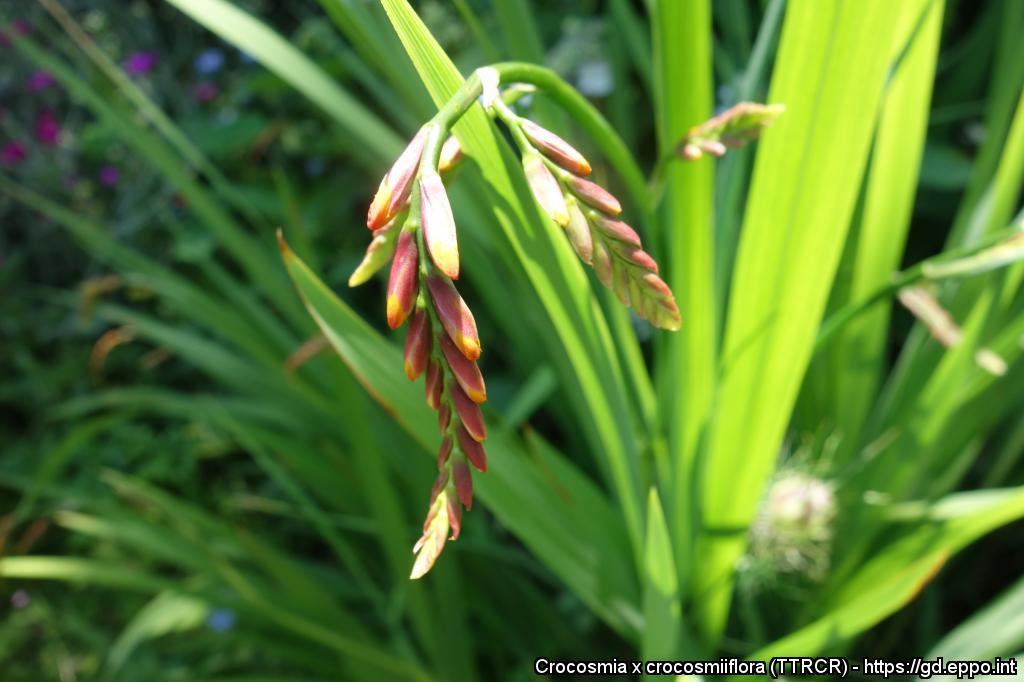

In [ ]:
print(question+'\nOptions:\n'+options_refactor(options)+end_prompt)
ds['test'][0]['image_1']

In [21]:
prompt='Describe the image. Try to guess the plant specie'
print(await chat(prompt,'/workdir/images/cache/prova.png'))

The image showcases a vibrant green plant with long, thin leaves and delicate red flowers, likely belonging to the Crocosmia genus, a type of flowering plant native to South Africa.

**Key Features:**

* The plant's slender stems are adorned with clusters of small, tubular flowers featuring a striking combination of red, yellow, and white hues.
* The leaves are long and thin, providing a lush backdrop for the colorful blooms.
* The flowers' shape is reminiscent of crocosmia, characterized by their curved petals.

**Background:**

* The background of the image features blurred greenery, suggesting that the plant is growing in a garden or natural setting.
